In [1]:
import jax.numpy as jnp
import pandas as pd
import matplotlib.pyplot as plt
from jax import random, value_and_grad, jit
from jax.numpy.fft import *
from jax.experimental.optimizers import adam
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Tanh, GeneralConv,
                                   Relu, LogSoftmax, elementwise)
from jax.nn.initializers import glorot_normal, normal, ones, zeros

from tqdm import tqdm

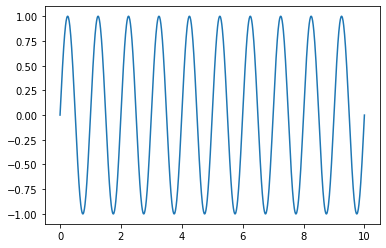

In [123]:
T = 0.01
t_max = 10
t = jnp.linspace(0, t_max, int(t_max/T))
s = jnp.sin(2*jnp.pi*t)
plt.plot(t, s)
plt.show()

/home/felipeangelim/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(-2.0, 2.0)

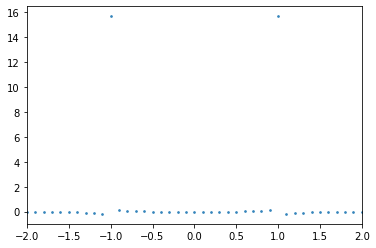

In [13]:
S = fftshift(fft(s))
F = fftshift(fftfreq(n=len(s),d=T))
plt.scatter(F, S, alpha=0.8, s=3)
plt.xlim((-2, 2))

In [14]:
def valor_de_pico(s):
    return jnp.max(jnp.abs(s))
def rms(s):
    return jnp.sqrt(jnp.mean(jnp.square(s)))

def fator_de_crista(s):
    return valor_de_pico(s)/rms(s)
    
    
@jit
def fator_tempo(s, t, freqs):
    
    dt = jnp.diff(t).mean()

    cr = fator_de_crista(s)

    S = fftshift(fft(s))
    F = fftshift(fftfreq(n=len(s),d=dt))

    # Indexes of excited frequencies
    
    diff = jnp.abs(jnp.repeat(jnp.expand_dims(F, axis=0), repeats = len(freqs), axis=0) - freqs.reshape((-1, 1)))
    freqs_indexes = jnp.argmin(diff, axis=-1)

    U = S[freqs_indexes]
    Urmse = jnp.sqrt(jnp.mean(jnp.square(jnp.abs(S))))
    U_min_k = jnp.min(jnp.square(jnp.abs(U)))

    result = 0.5*(cr**2)*(Urmse**2)/U_min_k
    
    return result
    

fator_tempo(s, t, jnp.array([1]))

DeviceArray(0.00200264, dtype=float32)

In [15]:
S[5010]

DeviceArray(-0.03145229+8.861818e-05j, dtype=complex64)

(-1.0, 1.0)

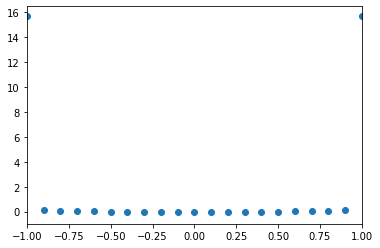

In [16]:
plt.scatter(F, S)
plt.xlim((-1, 1))

In [160]:
freqs=jnp.array([1, 0.4])
dt = jnp.diff(t).mean()

cr = fator_de_crista(s)

S = fftshift(fft(s))
F = fftshift(fftfreq(n=len(s),d=dt))

# Indexes of excited frequencies

diff = jnp.abs(jnp.repeat(jnp.expand_dims(F, axis=0), repeats = len(freqs), axis=0) - freqs.reshape((-1, 1)))
freqs_indexes = jnp.argmin(diff, axis=-1)

U = S[freqs_indexes]
Urmse = jnp.sqrt(jnp.mean(jnp.square(jnp.abs(S))))
U_min_k = jnp.min(jnp.square(jnp.abs(U)))

result = 0.5*(cr**2)*(Urmse**2)/U_min_k
result


DeviceArray(2211.1199, dtype=float32)

In [156]:
S[freqs_indexes]

DeviceArray([-0.07720745+1.8898106j ,  0.0056149 -0.47549206j], dtype=complex64)

In [157]:
jnp.min(jnp.square(jnp.abs(U)))

DeviceArray(0.22612424, dtype=float32)

In [158]:
fator_tempo(s, t, freqs=freqs)

DeviceArray(2211.1199, dtype=float32)

In [159]:
print(jnp.max(jnp.abs(S)))
print(F[jnp.argmax(jnp.abs(S))])

499.66364
0.999


In [18]:
fator_de_crista(s)

DeviceArray(1.4149193, dtype=float32)

In [204]:
rng = random.PRNGKey(15)

keys = random.split(rng, 3)
params = random.normal(keys[0], [int(t_max/T)])
#params = s

In [205]:
fator_tempo(params, t, freqs=jnp.array([1, 0.0503]))

DeviceArray(35.597214, dtype=float32)

In [206]:
step_size=0.0001
init_fun, opt_update, get_params = adam(step_size=step_size)
opt_state = init_fun(params)


def train_step( opt_state, opt_update, get_params, loss_fun, t, freqs):
    params = get_params(opt_state)
    loss, grad = value_and_grad(loss_fun)(params, t, freqs)
    opt_state = opt_update(0, grad, opt_state)
    params = get_params(opt_state)
    return get_params(opt_state), opt_state,  loss

loss_history = []
for i in tqdm(range(10000)):
    params, opt_state, loss = train_step(opt_state, opt_update, get_params, fator_tempo, jnp.array(t), jnp.array([1]))
    loss_history.append(loss)

100%|██████████| 10000/10000 [00:43<00:00, 229.03it/s]


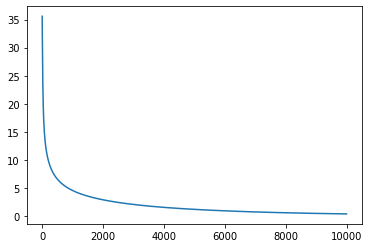

In [207]:
plt.plot(loss_history)

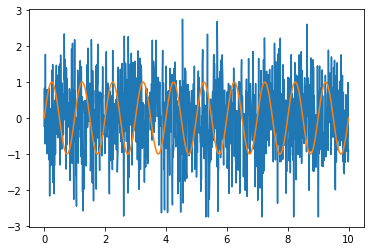

In [208]:
plt.plot(t, params)
plt.plot(t, s)
plt.show()

In [173]:
fator_tempo(params, t, freqs=jnp.array([1, 0.04]))

DeviceArray(9.701433, dtype=float32)

# Dense priors

In [253]:
init_fun, dense_net = stax.serial(
                                 Dense(len(t)),
                                 )



In [254]:
key = random.PRNGKey(1)

params = random.normal(key, (int(t_max/T),))
print(type(params))
_, dense_params = init_fun(key, params.shape)
dense_net(dense_params, params).shape

<class 'jax.interpreters.xla.DeviceArray'>


(1000,)

In [255]:
params[0]

DeviceArray(-1.0256945, dtype=float32)

In [256]:
step_size=0.0001
key = random.PRNGKey(1)

params = random.normal(key, (int(t_max/T),))
print(type(params))
_, dense_params = init_fun(key, params.shape)
dense_net(dense_params, params).shape


init_fun, opt_update, get_params = adam(step_size=step_size)

params = [params, dense_params]
opt_state = init_fun(params)

@jit
def _loss(params, t, freqs):
    dense_out = dense_net(params[1],params[0])
    return fator_tempo(dense_out, t, freqs)

def train_step( opt_state, opt_update, get_params, loss_fun, t, freqs):
    params = get_params(opt_state)
    loss, grad = value_and_grad(loss_fun)(params, t, freqs)
    opt_state = opt_update(0, grad, opt_state)
    params = get_params(opt_state)
    return get_params(opt_state), opt_state,  loss

loss_history = []
for i in tqdm(range(2000)):
    params, opt_state, loss = train_step(opt_state, opt_update, get_params, _loss, jnp.array(t), jnp.array([1, 0.5]))
    loss_history.append(loss)

  0%|          | 0/2000 [00:00<?, ?it/s]

<class 'jax.interpreters.xla.DeviceArray'>


100%|██████████| 2000/2000 [00:26<00:00, 75.75it/s]


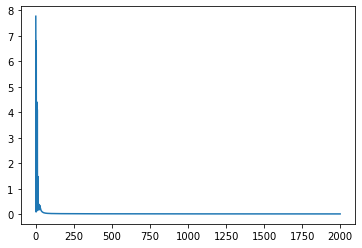

In [257]:
plt.plot(loss_history)

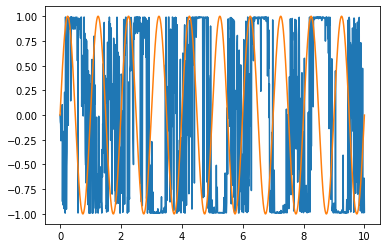

In [260]:
dense_out = dense_net(params[1],params[0]) 
plt.plot(t, dense_out)
plt.plot(t, s)
plt.show()

/home/felipeangelim/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


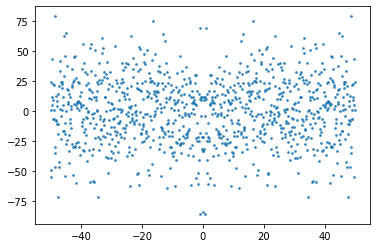

In [261]:
S = fftshift(fft(dense_net(params[1],params[0])))
F = fftshift(fftfreq(n=len(s),d=T))
plt.scatter(F, S, alpha=0.8, s=3)
#plt.xlim((-2, 2))

In [277]:
params

DeviceArray([-2.0490463,  2.09473  , -1.7288076, ..., -2.82636  ,
              3.4406648, -1.206364 ], dtype=float32)

# Convolutional Prior

1. Fixed net

2. Trainable net

In [275]:
size = int(t_max/T)
params = random.normal(key, (1, 1, 1, size))
print(type(params))
init_fun, conv_net = stax.serial(Conv(32, (1, 5), (1, 1), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (1, 5), (1, 1), padding="SAME"),
                                 Relu,
                                 Dense(size),
                                 Flatten,
                                 Tanh)

init_fun, conv_net = stax.serial(Conv(32, (1, 20), (1, 1), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (1, 15), (1, 1), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (1, 10), (1, 1), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(32, (1, 5), (1, 1), padding="SAME"),
                                 BatchNorm(), Relu,
                                 Conv(size, (1, 5), (1, 1), padding="SAME"),
                                 Flatten)


_, conv_params = init_fun(key, (1, 1, 1, size))

<class 'jax.interpreters.xla.DeviceArray'>


In [276]:
conv_net(conv_params, params).shape

(1, 1000)

  0%|          | 0/2000 [00:00<?, ?it/s]

(1, 1, 1, 1000)


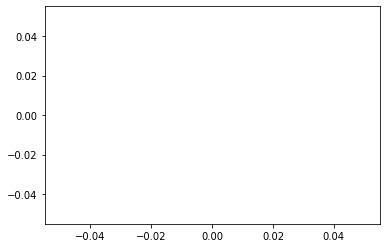

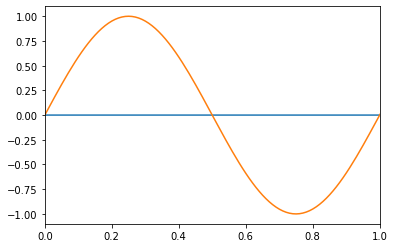

 25%|██▍       | 499/2000 [00:26<01:08, 21.85it/s]

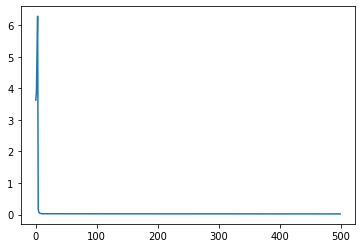

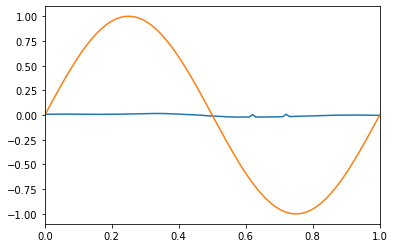

 50%|████▉     | 999/2000 [00:50<00:44, 22.52it/s]

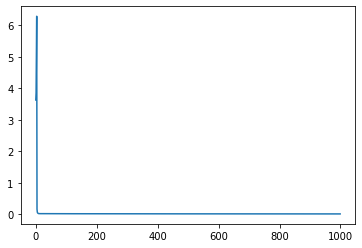

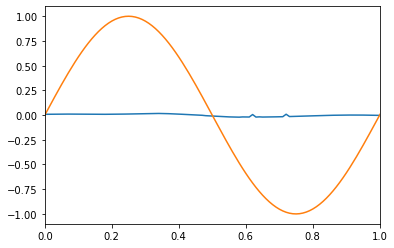

 75%|███████▌  | 1500/2000 [01:14<00:27, 18.12it/s]

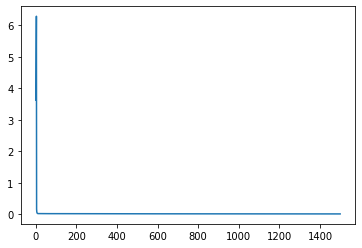

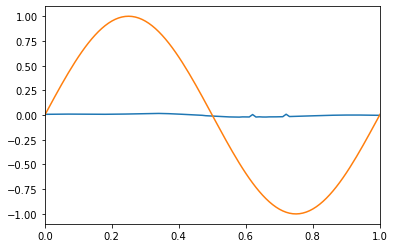

100%|██████████| 2000/2000 [01:40<00:00, 19.88it/s]


In [277]:
step_size=1e-3
init_fun, opt_update, get_params = adam(step_size=step_size)

print(params.shape)
params = [params, conv_params]

opt_state = init_fun(params)

@jit
def _loss(params, t, freqs):
    conv_out = conv_net(params[1], params[0]).flatten()
    noise = random.normal(rng, conv_out.shape)*0.001
    return fator_tempo(conv_out + noise, t, freqs)

def train_step( opt_state, opt_update, get_params, loss_fun, t, freqs):
    params = get_params(opt_state)
    loss, grad = value_and_grad(loss_fun)(params, t, freqs)
    opt_state = opt_update(0, grad, opt_state)
    params = get_params(opt_state)
    return get_params(opt_state), opt_state,  loss

loss_history = []
for i in tqdm(range(2000)):
    if i % 500 == 0:
        plt.plot(loss_history)
        plt.show()
        
        plt.plot(t, conv_net(params[1], params[0]).flatten())
        plt.plot(t, s)
        plt.xlim((0, 1))
        plt.show()
        
    params, opt_state, loss = train_step(opt_state, opt_update, get_params, _loss, jnp.array(t), jnp.array([0.5, 1, 1.7, 2]))
    loss_history.append(loss)

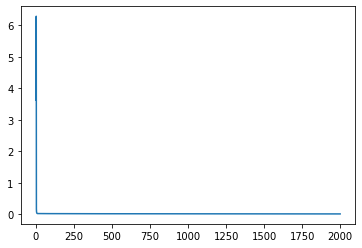

In [278]:
plt.plot(loss_history)

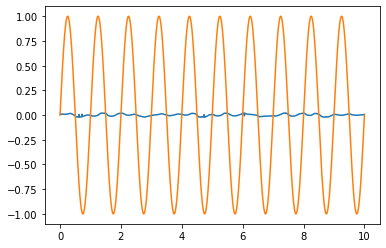

In [279]:
plt.plot(t, conv_net(params[1], params[0]).flatten())
plt.plot(t, s)
plt.show()

/home/felipeangelim/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


(-2.0, 2.0)

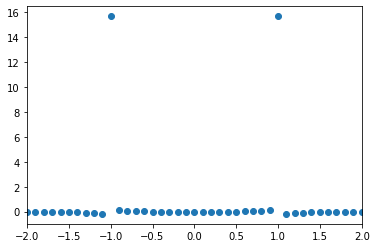

In [280]:
dt = jnp.diff(t).mean()
S = fftshift(fft(s))
F = fftshift(fftfreq(n=len(s),d=dt))

plt.scatter(F, S)
plt.xlim((-2, 2))

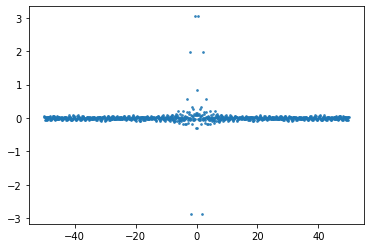

In [283]:
S = fftshift(fft(conv_net(params[1],params[0])))
F = fftshift(fftfreq(n=len(s),d=T))
plt.scatter(F, S, alpha=0.8, s=3)
#plt.xlim((-2, 2))

# GRU

In [86]:
from jax.nn import sigmoid
from jax.nn.initializers import glorot_normal, normal

from functools import partial
from jax import lax

def GRU(out_dim, W_init=glorot_normal(), b_init=normal()):
    def init_fun(rng, input_shape):
        """ Initialize the GRU layer for stax """
        hidden = b_init(rng, (input_shape[0], out_dim))

        k1, k2, k3 = random.split(rng, num=3)
        update_W, update_U, update_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        reset_W, reset_U, reset_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)

        k1, k2, k3 = random.split(rng, num=3)
        out_W, out_U, out_b = (
            W_init(k1, (input_shape[2], out_dim)),
            W_init(k2, (out_dim, out_dim)),
            b_init(k3, (out_dim,)),)
        # Input dim 0 represents the batch dimension
        # Input dim 1 represents the time dimension (before scan moveaxis)
        output_shape = (input_shape[0], input_shape[1], out_dim)
        return (output_shape,
            (hidden,
             (update_W, update_U, update_b),
             (reset_W, reset_U, reset_b),
             (out_W, out_U, out_b),),)

    def apply_fun(params, inputs, **kwargs):
        """ Loop over the time steps of the input sequence """
        h = params[0]

        def apply_fun_scan(params, hidden, inp):
            """ Perform single step update of the network """
            _, (update_W, update_U, update_b), (reset_W, reset_U, reset_b), (
                out_W, out_U, out_b) = params

            update_gate = sigmoid(jnp.dot(inp, update_W) +
                                  jnp.dot(hidden, update_U) + update_b)
            reset_gate = sigmoid(jnp.dot(inp, reset_W) +
                                 jnp.dot(hidden, reset_U) + reset_b)
            output_gate = jnp.tanh(jnp.dot(inp, out_W)
                                  + jnp.dot(jnp.multiply(reset_gate, hidden), out_U)
                                  + out_b)
            output = jnp.multiply(update_gate, hidden) + jnp.multiply(1-update_gate, output_gate)
            hidden = output
            return hidden, hidden

        # Move the time dimension to position 0
        inputs = jnp.moveaxis(inputs, 1, 0)
        f = partial(apply_fun_scan, params)
        _, h_new = lax.scan(f, h, inputs)
        return h_new

    return init_fun, apply_fun

In [93]:
key = random.PRNGKey(1)
size = int(t_max/T)
shape = (1,  1, size)
params = random.normal(key, shape)
print(type(params))

init_fun, gru_rnn = stax.serial(GRU(size), Flatten)
_, gru_params = init_fun(key, shape)

<class 'jax.interpreters.xla.DeviceArray'>


In [94]:
gru_rnn(gru_params, params).shape

(1, 1000)

  0%|          | 0/10000 [00:00<?, ?it/s]

(1, 1, 1000)


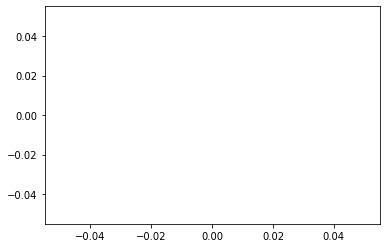

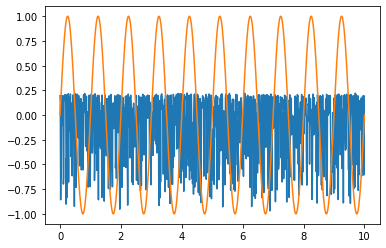

  5%|▍         | 499/10000 [00:35<10:22, 15.25it/s]

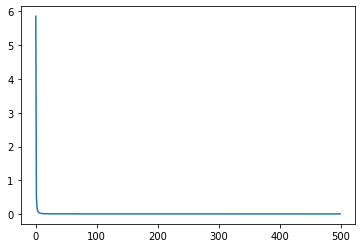

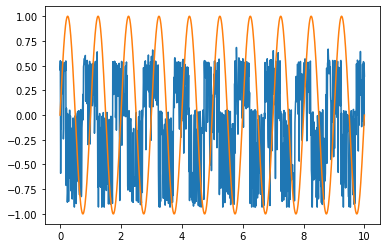

 10%|▉         | 999/10000 [01:08<09:43, 15.42it/s]

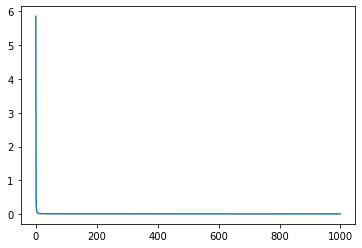

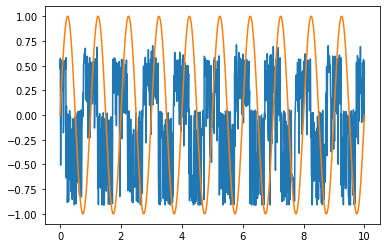

 15%|█▍        | 1499/10000 [01:42<09:15, 15.31it/s]

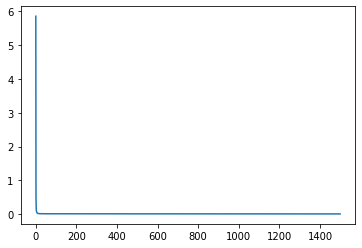

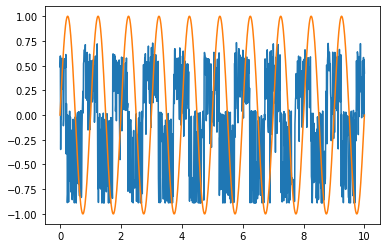

 20%|█▉        | 1999/10000 [02:15<08:24, 15.87it/s]

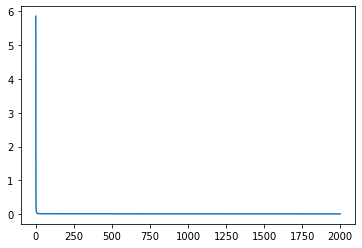

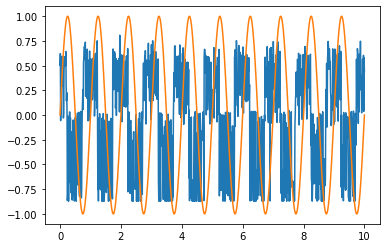

 25%|██▍       | 2499/10000 [02:48<08:13, 15.21it/s]

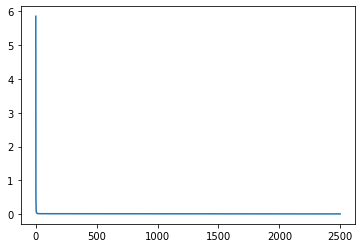

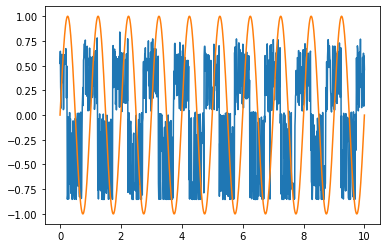

 28%|██▊       | 2798/10000 [03:08<08:04, 14.87it/s]


KeyboardInterrupt: 

In [95]:
step_size=1e-4
init_fun, opt_update, get_params = adam(step_size=step_size)

print(params.shape)
params = [params, gru_params]

opt_state = init_fun(params)

@jit
def _loss(params, t, freqs):
    out = gru_rnn(params[1], params[0]).flatten()
    return fator_tempo(out, t, freqs)# + jnp.mean((jnp.square(jnp.diff(out))))

#@jit
#def _loss(params, t, freqs):
#    out = gru_rnn(params[1], params[0]).flatten()
#    true = jnp.sin(2*jnp.pi*t)
#    return jnp.mean(jnp.square(out - true))

def train_step( opt_state, opt_update, get_params, loss_fun, t, freqs):
    params = get_params(opt_state)
    loss, grad = value_and_grad(loss_fun)(params, t, freqs)
    opt_state = opt_update(0, grad, opt_state)
    params = get_params(opt_state)
    return get_params(opt_state), opt_state,  loss

loss_history = []
for i in tqdm(range(10000)):
    if i % 500 == 0:
        plt.plot(loss_history)
        plt.show()
        
        plt.plot(t, gru_rnn(params[1], params[0]).flatten())
        plt.plot(t, s)
        #plt.xlim((0, 1))
        plt.show()
        
    params, opt_state, loss = train_step(opt_state, opt_update, get_params, _loss, jnp.array(t), jnp.array([1]))
    loss_history.append(loss)

In [478]:
out = gru_rnn(params[1], params[0]).flatten()

In [479]:
jnp.mean((jnp.square(jnp.diff(out))))

DeviceArray(1.8113984, dtype=float32)